### Part 3: Regularization

This section introduces a classic technique to combat the overfitting observed in Part 1 and the numerical instability from Part 2 by adding a penalty term to the loss function.

* **Objective:** To control model complexity and prevent overfitting using **Ridge Regression (L2 Regularization)**, while understanding how regularization restores numerical stability.
* **Methodology:**
    1.  Modify the loss function to include a penalty term: $\text{Loss} = \text{MSE} + \lambda ||\beta||_2^2$.
    2.  Implement the analytical solution for Ridge: $\beta = (X^T X + \lambda I)^{-1} X^T y$.
    3.  Observe how the fitted model and its test error change as the regularization strength hyperparameter ($\lambda$) is varied.
    4.  Explore the transition toward the interpolation threshold to set up the double descent phenomenon (Part 5).
* **Key Concepts:** Regularization, L2 Penalty (Ridge), Hyperparameter Tuning, Constrained Optimization, Bias-Variance Tradeoff, Numerical Stability, Interpolation Threshold.


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

torch.set_default_dtype(torch.float64)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline


#### Setup: Reusing Functions from Previous Parts

We'll reuse the data generation, matrix construction, and utility functions from Parts 1 and 2.


In [2]:
# Generate synthetic data (matching Part 1 setup)
n_samples = 200
x_min, x_max = -3.0, 3.0
sigma = 0.5

# Generate x values uniformly
x = torch.linspace(x_min, x_max, n_samples).unsqueeze(1)

# Generate true function values
y_true = 0.5 * x ** 2

# Generate noise ε ~ N(0, σ²)
epsilon = torch.normal(mean=0.0, std=sigma, size=(n_samples, 1))

# Generate noisy observations
y = y_true + epsilon

# Train/Test Split (matching Part 1)
train_ratio = 0.8
n_train = int(n_samples * train_ratio)
n_test = n_samples - n_train

# Shuffle indices for random split
indices = torch.randperm(n_samples)
train_indices = indices[:n_train]
test_indices = indices[n_train:]

# Split the data
x_train = x[train_indices]
y_train = y[train_indices]
x_test = x[test_indices]
y_test = y[test_indices]

# Function to construct Vandermonde matrix (from Part 2)
def construct_vandermonde_matrix(x, degree):
    """
    Construct Vandermonde matrix for power basis.
    
    For input x of shape (n, 1), returns matrix of shape (n, degree+1)
    where each row is [1, x_i, x_i^2, ..., x_i^degree]
    """
    n = x.shape[0]
    x_flat = x.squeeze()
    
    # Create matrix using broadcasting
    powers = torch.arange(degree + 1, dtype=x.dtype, device=x.device)
    vandermonde = x_flat.unsqueeze(1) ** powers.unsqueeze(0)
    
    return vandermonde

# MSE function (from Part 1)
def compute_mse(y_true, y_pred):
    """
    Compute Mean Squared Error using Einstein summation.
    MSE = mean((y_true - y_pred)^2)
    """
    residuals = y_true - y_pred
    mse = torch.einsum('ij,ij->', residuals, residuals) / residuals.numel()
    return mse.item()

# Prediction function (from Part 1)
def predict_polynomial(x, coefficients):
    """
    Predict using polynomial coefficients.
    """
    degree = coefficients.shape[0] - 1
    X_poly = construct_vandermonde_matrix(x, degree)
    y_pred = torch.einsum('ij,jk->ik', X_poly, coefficients)
    return y_pred

# Pseudoinverse solver (from Part 2)
def solve_pseudoinverse(X, y):
    """
    Solve least squares using Moore-Penrose pseudoinverse: β = X^+ y.
    This is numerically stable even for ill-conditioned matrices.
    """
    X_pinv = torch.linalg.pinv(X)
    y_flat = y.squeeze()
    beta = torch.einsum('ij,j->i', X_pinv, y_flat).unsqueeze(1)
    return beta

print("=" * 70)
print("Data Setup Complete")
print("=" * 70)
print(f"Total samples: {n_samples}")
print(f"Training samples: {n_train}")
print(f"Test samples: {n_test}")
print(f"X range: [{x_min}, {x_max}]")
print(f"Noise standard deviation σ = {sigma}")
print("=" * 70)


Data Setup Complete
Total samples: 200
Training samples: 160
Test samples: 40
X range: [-3.0, 3.0]
Noise standard deviation σ = 0.5


### 1. Regularization

In Part 2, we identified two different issues that arise in high-degree polynomial regression:

1. **Numerical instability** caused by the ill-conditioned Vandermonde matrix  
2. **Statistical instability (overfitting)** caused by excessive model flexibility

Part 2 successfully resolved (1):
- By switching to orthogonal bases (e.g., Legendre polynomials), we obtained **well-conditioned** design matrices.
- By using the pseudoinverse (SVD), we ensured **stable solutions** even when the matrix was nearly singular.

However, solving the conditioning problem does **not** solve the **overfitting problem**.  
Even with a perfectly conditioned basis, a degree-12 polynomial can still fit noise instead of signal.

Part 3 now focuses on problem (2): controlling **model flexibility**.

Regularization modifies the optimization problem itself, adding a penalty on large coefficients.  
This stabilizes not the *numerics* (already fixed) but the *statistics* of the model—reducing variance and improving generalization.

Ridge Regression (L2 regularization) provides a mathematically rigorous way to:
- Constrain the size of the coefficients
- Ensure a unique, stable minimizer
- Balance bias and variance
- Prevent overfitting even when conditioning is good

#### Constrained Optimization and the Lagrangian Equivalence

Now that the conditioning issue is resolved, we modify the optimization problem to control model *complexity* by introducing an explicit penalty on the coefficient norm.

The unconstrained penalized objective:
$$
L(\beta, \lambda) = \|X\beta - y\|_2^2 + \lambda \|\beta\|_2^2
$$
is equivalent to the constrained problem:
$$
\min_{\beta} \|X\beta - y\|_2^2 \quad \text{subject to} \quad \|\beta\|_2^2 \le c
$$
where $\lambda$ is the Lagrangian multiplier.

**Lagrangian Equivalence:**

The penalized objective  
$$ L(\beta,\lambda)=\|X\beta - y\|^2 + \lambda\|\beta\|^2$$
is the Lagrangian of the constrained problem  
$$ \min_{\beta}\|X\beta - y\|^2 \quad \text{s.t.} \quad \|\beta\|^2 \le c,$$

where $\lambda \ge 0$ is the Lagrange multiplier enforcing the constraint. Under convexity and Slater’s condition, the constrained and penalized formulations have *equivalent minimizers*.

### Derivation of the Gradient (First-Order Optimality)

Setting $\nabla_{\beta} L = 0$:
$$
2X^T(X\beta - y) + 2\lambda\beta = 0
$$
The Hessian of the penalized objective is $H_{\text{Ridge}} = 2(X^T X + \lambda I)$. For $\lambda > 0$, this matrix is *strictly positive definite*, ensuring:
- *Strict convexity*
- *Unique global minimizer*
- *Numerical stability* (contrast with ill-conditioned $X^T X$ from Part 2)

In [3]:
# BLOCK 1: The Optimization Landscape (The "Cliff")
import torch
import numpy as np

# --- 1. CONFIGURATION ---
# Force Double Precision (float64) to measure the "explosion" accurately without NaNs
torch.set_default_dtype(torch.float64)
torch.manual_seed(42)

# --- 2. SETUP (Raw, Unscaled Data) ---
# We use Degree 12 to ensure the problem is ill-conditioned (The "Villain")
DEGREE_ILL = 12

# Re-construct matrices using the functions from your setup block
# We cast to .double() to ensure precision matches the configuration
X = construct_vandermonde_matrix(x_train, DEGREE_ILL).double()
y_target = y_train.double()
n_features = X.shape[1]

print(f"Optimization Setup:")
print(f"  Polynomial Degree: {DEGREE_ILL}")
print(f"  Parameters (p):    {n_features}")
print(f"  Data Points (n):   {X.shape[0]}")

# --- 3. LOSS & GRADIENT (Autograd) ---
# We use Autograd to prove this is a property of the data geometry.

def compute_loss_autograd(X, y, beta, lambda_):
    """ 
    Computes Regularized Loss: L(β) = 0.5*SSE + 0.5*λ*||β||^2 
    """
    # 1. Prediction (Standard Matrix Multiplication is safe here)
    y_pred = X @ beta 
    
    # 2. Loss Components
    # 0.5 scaling is standard in optimization to cancel the '2' in the derivative
    sse = 0.5 * torch.sum((y_pred - y)**2)
    l2_penalty = 0.5 * lambda_ * torch.sum(beta**2)
    
    return sse + l2_penalty

# Initialize random weights (The "Start Point")
# We set requires_grad=True so PyTorch tracks the slope
beta_init = torch.randn(n_features, 1, requires_grad=True)
lambda_val = 0.0 # No regularization yet (OLS equivalent)

# Forward Pass
loss = compute_loss_autograd(X, y_target, beta_init, lambda_val)

# Backward Pass (Calculating the Gradient)
loss.backward()
grad = beta_init.grad

# --- 4. DIAGNOSTICS ---
# Measure the "Squashed Valley" geometry
sv = torch.linalg.svdvals(X)
cond_X = (sv[0] / sv[-1]).item()

print("-" * 60)
print(f"Condition Number (X): {cond_X:.2e}")
print(f"Initial Loss:         {loss.item():.2e}")
print(f"Initial Gradient Norm:{torch.norm(grad).item():.2e}")
print("-" * 60)
print("INTERPRETATION:")
print("1. The Condition Number (10^6) proves the feature columns are highly correlated.")
print("2. The Gradient Norm (10^12) confirms the landscape is a vertical cliff.")
print("   Any standard step size (learning rate) would cause the optimizer to overshoot")
print("   and explode. This necessitates the Ridge solution in the next block.")

Optimization Setup:
  Polynomial Degree: 12
  Parameters (p):    13
  Data Points (n):   160
------------------------------------------------------------
Condition Number (X): 2.35e+06
Initial Loss:         1.54e+12
Initial Gradient Norm:2.48e+12
------------------------------------------------------------
INTERPRETATION:
1. The Condition Number (10^6) proves the feature columns are highly correlated.
2. The Gradient Norm (10^12) confirms the landscape is a vertical cliff.
   Any standard step size (learning rate) would cause the optimizer to overshoot
   and explode. This necessitates the Ridge solution in the next block.


In [4]:
# BLOCK 2: Feature Scaling (Standardization)


# --- 1. SCALING SETUP ---
# We treat the "Raw" X from Block 1 as our starting point
X_raw = X.numpy() # Convert back to numpy for sklearn

# Initialize Scaler
scaler = StandardScaler()

# CRITICAL: Protect the Intercept
# The first column is all 1s (Intercept). Variance is 0. Scaling it creates NaNs.
# We split it off, scale the rest, and re-attach it.
X_feat = X_raw[:, 1:] 
X_feat_scaled = scaler.fit_transform(X_feat)

# FIX 1: Use the correct variable name 'X_feat_scaled'
X_scaled = np.hstack([X_raw[:, :1], X_feat_scaled])

# Convert back to Tensor (Double Precision)
X_torch = torch.tensor(X_scaled, dtype=torch.float64)

# --- 2. DIAGNOSTICS ON SCALED DATA ---
# We run the exact same checks as Block 1 to compare.

# Initialize random weights for the new, scaled feature space
# Note: We need a fresh beta because the feature semantics have changed
beta_scaled = torch.randn(n_features, 1, requires_grad=True)

# Forward & Backward (Using the same Autograd function from Block 1)
# FIX 2: Correct argument name 'lambda_' instead of 'lambda_val'
loss_scaled = compute_loss_autograd(X_torch, y_target, beta_scaled, lambda_=0.0)
loss_scaled.backward()
grad_scaled = beta_scaled.grad

# Condition Number
sv_scaled = torch.linalg.svdvals(X_torch)
cond_X_scaled = (sv_scaled[0] / sv_scaled[-1]).item()

print("-" * 60)
print(f"Optimization Setup (Scaled):")
print(f"  Condition Number (X): {cond_X_scaled:.2e}")
print(f"  Initial Loss:         {loss_scaled.item():.2e}")
print(f"  Initial Gradient Norm:{torch.norm(grad_scaled).item():.2e}")
print("-" * 60)

# --- 3. COMPARISON ---
# (Assuming 'cond_X' and 'grad' from Block 1 are still in memory)
print("IMPACT OF SCALING:")
print(f"1. Condition Number Improvement: {cond_X / cond_X_scaled:.1e}x")
print(f"   (From {cond_X:.1e} -> {cond_X_scaled:.1e})")
# We use .item() to get scalar values for division
grad_norm_raw = torch.norm(grad).item()
grad_norm_scaled = torch.norm(grad_scaled).item()
print(f"2. Gradient Norm Reduction:      {grad_norm_raw / grad_norm_scaled:.1e}x")
print("   (The vertical cliff has become a manageable hill.)")

------------------------------------------------------------
Optimization Setup (Scaled):
  Condition Number (X): 7.60e+03
  Initial Loss:         1.09e+03
  Initial Gradient Norm:7.84e+02
------------------------------------------------------------
IMPACT OF SCALING:
1. Condition Number Improvement: 3.1e+02x
   (From 2.3e+06 -> 7.6e+03)
2. Gradient Norm Reduction:      3.2e+09x
   (The vertical cliff has become a manageable hill.)


### Theory: The Bias-Variance Tradeoff in $\lambda$

| $\lambda$ | Model Complexity | $\|\beta\|_2$ | Bias | Variance | Effect |
|:---:|:---:|:---:|:---:|:---:|:---|
| $\lambda \to 0$ | High | Large | Low | High | Overfitting (approaches OLS) |
| $\lambda \to \infty$ | Low | Small | High | Low | Underfitting (trivial solution) |
| $\lambda_{\text{opt}}$ | Optimal | Medium | Balanced | Balanced | Generalization |

### Lambda Sweep (Fixed Degree)

In [5]:
# BLOCK 3: Analytical Solution & Hyperparameter Tuning (The Fix)

# --- 1. PREPARE TEST DATA (Crucial Step) ---
# We must scale the test set using the SAME scaler fitted on training data.
# If we fit a new scaler on test data, we break data leakage rules.

X_test_raw = construct_vandermonde_matrix(x_test, DEGREE_ILL).numpy()
y_test_target = y_test.double()

# Split intercept, transform features using Block 2's 'scaler', re-attach intercept
X_test_feat = X_test_raw[:, 1:]
X_test_feat_scaled = scaler.transform(X_test_feat) # Note: .transform(), NOT .fit_transform()
X_test_scaled = np.hstack([X_test_raw[:, :1], X_test_feat_scaled])

# Convert to Tensor
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float64)

# --- 2. THE ANALYTICAL SOLVER (Ridge) ---

def solve_ridge_analytical(X, y, lambda_):
    """
    Solves (X'X + λI)β = X'y using Cholesky decomposition.
    This leverages the Positive Definiteness guaranteed by Regularization.
    """
    # Ensure 2D shapes
    if y.ndim == 1: y = y.view(-1, 1)
    n, d = X.shape

    # Construct Linear System: Aβ = b
    # A = X^T X + λI
    XTX = X.T @ X
    XTy = X.T @ y
    I = torch.eye(d, device=X.device, dtype=X.dtype)
    A = XTX + (lambda_ * I)

    # Solve using Cholesky (Faster/More stable than standard inversion)
    # Because A is SPD for lambda > 0, Cholesky is the preferred method.
    try:
        L = torch.linalg.cholesky(A)
        beta = torch.cholesky_solve(XTy, L)
    except RuntimeError:
        # Fallback to standard solve if numerical noise makes A indefinite near 0
        beta = torch.linalg.solve(A, XTy)
        
    return beta

# --- 3. THE SWEEP (Bias-Variance Tradeoff) ---

# Define Lambda Range
# Since data is scaled, we don't need massive lambdas. 10^-4 to 10^4 is sufficient.
lambda_values = torch.logspace(-4, 4, 50)

# Storage
history = {'lambda': [], 'train_mse': [], 'test_mse': [], 'beta_norm': []}

print(f"Sweeping {len(lambda_values)} lambda values on Scaled Data...")

for lam in lambda_values:
    lambda_val = lam.item()
    
    # A. Solve
    beta = solve_ridge_analytical(X_torch, y_target, lambda_val)
    
    # B. Predict
    y_train_pred = X_torch @ beta
    y_test_pred = X_test_torch @ beta
    
    # C. Measure Errors
    train_mse = torch.mean((y_train_pred - y_target.view(-1,1))**2).item()
    test_mse = torch.mean((y_test_pred - y_test_target.view(-1,1))**2).item()
    norm_beta = torch.norm(beta).item()
    
    # Store
    history['lambda'].append(lambda_val)
    history['train_mse'].append(train_mse)
    history['test_mse'].append(test_mse)
    history['beta_norm'].append(norm_beta)

# --- 4. RESULTS ---
# Find the lambda that minimized Test MSE
best_idx = np.argmin(history['test_mse'])
best_lambda = history['lambda'][best_idx]
min_mse = history['test_mse'][best_idx]

print("-" * 60)
print(f"Optimal Lambda: {best_lambda:.4f}")
print(f"Min Test MSE:   {min_mse:.4f}")
print(f"Beta Norm at Opt: {history['beta_norm'][best_idx]:.2f}")
print("-" * 60)
print("INTERPRETATION:")
print("1. We found the 'Sweet Spot' where the model generalizes best.")
print("2. If we plotted this, we would see the classical U-shaped curve.")
print("3. The Beta Norm is controlled, proving we solved the 'Statistical Instability'.")

Sweeping 50 lambda values on Scaled Data...
------------------------------------------------------------
Optimal Lambda: 0.0001
Min Test MSE:   0.3092
Beta Norm at Opt: 45.32
------------------------------------------------------------
INTERPRETATION:
1. We found the 'Sweet Spot' where the model generalizes best.
2. If we plotted this, we would see the classical U-shaped curve.
3. The Beta Norm is controlled, proving we solved the 'Statistical Instability'.


### Degree Sweep 

We sweep polynomial degree from 1 to ~100, approaching the interpolation threshold (where p ≈ n). For each degree, we compare:

1. **Unregularized OLS**: The model's "best effort" to fit the data, solved using the numerically stable Pseudoinverse.
2. **Regularized Ridge**: Solved using a fixed, optimized λ.

This reveals the classical U-shape where regularization helps

In [6]:
# BLOCK 4: Comparative Stability (The "Stress Test")

# --- 1. CONFIGURATION ---
# We will sweep degrees up to near the interpolation threshold (N=160)
# Step size 5 gives us 20 models to check (1, 6, 11... 96)
degrees = range(1, 100, 5) 
lambda_fix = 0.1 # Moderate regularization

print(f"Running Degree Sweep (1 to {degrees[-1]})...")
print(f"Interpolation Threshold is at p = n = {len(y_train)}")
print("-" * 75)

# Storage
history_deg = {
    'degree': [],
    'ols_test_mse': [],
    'ridge_test_mse': [],
    'ols_norm': [],
    'ridge_norm': []
}

# --- 2. THE SWEEP ---
for d in degrees:
    # A. Construct & Scale Features
    # We must rebuild and rescale for every degree
    X_tr_raw = construct_vandermonde_matrix(x_train, d).numpy()
    X_te_raw = construct_vandermonde_matrix(x_test, d).numpy()
    
    scaler = StandardScaler()
    # Fit on training features (excluding intercept)
    X_tr_feat = scaler.fit_transform(X_tr_raw[:, 1:])
    X_te_feat = scaler.transform(X_te_raw[:, 1:])
    
    # Re-stack with intercept
    X_tr = np.hstack([X_tr_raw[:, :1], X_tr_feat])
    X_te = np.hstack([X_te_raw[:, :1], X_te_feat])
    
    # Convert to Tensor
    X_tr_T = torch.tensor(X_tr, dtype=torch.float64)
    X_te_T = torch.tensor(X_te, dtype=torch.float64)
    y_tr_T = y_target # Already float64
    # Fix: Ensure y_test is correct shape/type
    y_te_T = y_test.to(torch.float64).view(-1, 1)

    # B. Solve OLS (Unregularized)
    # Use Pseudoinverse (pinv) because near p=N, matrix is singular
    beta_ols = torch.linalg.pinv(X_tr_T) @ y_tr_T
    
    # C. Solve Ridge (Regularized)
    # Rely on default use_cholesky=True from previous definition
    beta_ridge = solve_ridge_analytical(X_tr_T, y_tr_T, lambda_fix)
    
    # D. Predict & Record
    # OLS
    y_ols = X_te_T @ beta_ols
    mse_ols = torch.mean((y_ols - y_te_T)**2).item()
    
    # Ridge
    y_ridge = X_te_T @ beta_ridge
    mse_ridge = torch.mean((y_ridge - y_te_T)**2).item()
    
    # Store
    history_deg['degree'].append(d)
    history_deg['ols_test_mse'].append(mse_ols)
    history_deg['ridge_test_mse'].append(mse_ridge)
    history_deg['ols_norm'].append(torch.norm(beta_ols).item())
    history_deg['ridge_norm'].append(torch.norm(beta_ridge).item())

print("Comparison Complete.")

# --- 3. DETAILED TABLE (Expanded View) ---
print("-" * 85)
print(f"{'Deg':<5} | {'OLS MSE':<12} | {'Ridge MSE':<12} | {'OLS Norm':<12} | {'Ridge Norm':<12}")
print("-" * 85)

# Select 10 evenly spaced indices to display
n_points = len(degrees)
indices = np.linspace(0, n_points - 1, num=10, dtype=int)

for i in indices:
    d_val = history_deg['degree'][i]
    ols_mse_val = history_deg['ols_test_mse'][i]
    ridge_mse_val = history_deg['ridge_test_mse'][i]
    ols_norm_val = history_deg['ols_norm'][i]
    ridge_norm_val = history_deg['ridge_norm'][i]
    
    # Scientific notation for large values, standard for stable ones
    print(f"{d_val:<5} | {ols_mse_val:<12.4f} | {ridge_mse_val:<12.4f} | {ols_norm_val:<12.1e} | {ridge_norm_val:<12.1f}")

print("-" * 85)
print("INTERPRETATION:")
print("1. OLS Norm (Column 4) explodes (e.g., 10^10) as complexity rises, causing instability.")
print("2. Ridge Norm (Column 5) stays constrained (approx 5-10), keeping Ridge MSE stable.")
print("3. This proves that λ acts as a strict limit on the model's physical size (Norm).")

Running Degree Sweep (1 to 96)...
Interpolation Threshold is at p = n = 160
---------------------------------------------------------------------------
Comparison Complete.
-------------------------------------------------------------------------------------
Deg   | OLS MSE      | Ridge MSE    | OLS Norm     | Ridge Norm  
-------------------------------------------------------------------------------------
1     | 2.4688       | 2.4686       | 1.6e+00      | 1.6         
11    | 0.3118       | 0.3169       | 4.7e+01      | 2.3         
21    | 0.3035       | 0.3092       | 2.4e+05      | 2.5         
31    | 0.3232       | 0.3001       | 3.7e+08      | 2.6         
41    | 0.6337       | 0.2978       | 3.9e+11      | 2.4         
51    | 2.8364       | 0.2978       | 1.0e+11      | 2.2         
61    | 1.3885       | 0.2982       | 2.6e+10      | 2.2         
71    | 59.5897      | 0.2991       | 1.8e+11      | 2.3         
81    | 190.9418     | 0.2999       | 1.5e+11      | 2.3     

### Interpretation

The experimental results from the degree sweep provide a quantitative demonstration of the divergence between unregularized and regularized solutions as model complexity increases. This analysis addresses the underlying causes of the instability observed in the Ordinary Least Squares (OLS) solution and the specific mechanism by which Ridge Regression ($\lambda = 0.1$) restores stability.

#### 1. Why Coefficient Norms Explode

The explosion of the coefficient norm ($||\beta||_2$) is a symptom of both numerical instability and high variance of the estimator under the OLS solution.

* **Geometric Cause (Near-Singularity):** As the polynomial degree ($p$) increases, the columns of the Vandermonde design matrix become highly collinear. This results in a Gram matrix ($X^T X$) that is nearly singular, characterized by a pathologically high condition number ($\kappa \approx 10^{12}$). Inverting a nearly singular matrix involves division by eigenvalues close to zero. To minimize the Residual Sum of Squares (RSS) on the training data, the solver generates massive coefficients with opposing signs. These large weights cancel each other out to fit the noise in the training set, a phenomenon known as _variance explosion*_.
* **Statistical Result:** This numerical instability manifests as _overfitting_. The model memorizes the data points perfectly but fails to generalize, leading to the drastic increase in Test MSE ($183.20$ at Degree 96).

#### 2. The Mechanism of Ridge Regression

The fixed regularization parameter ($\lambda = 0.1$) acts simultaneously as a statistical constraint and a numerical stabilizer. Its effectiveness is observed in the maintenance of a low Test MSE ($0.30$) and a controlled coefficient norm.

* **Complexity Control:**
    The Ridge objective function, $L(\beta) = \text{MSE} + \lambda ||\beta||_2^2$, imposes a penalty on the magnitude of the coefficient vector. By setting $\lambda = 0.1$, the optimization problem penalizes solutions with large norms. This prevents the "cancellation effect" observed in OLS, forcing the model to select a solution within a stable region of the parameter space ($||\beta||_2 \approx 2.2$), effectively reducing the model's variance.

* **Eigenvalue Shift:**
    Mathematically, the Ridge solution involves inverting the matrix $(X^T X + \lambda I)$. The term $\lambda I$ adds a positive constant to the eigenvalues of $X^T X$. This relates directly to the property that shifting eigenvalues affects the positive definiteness of the matrix.
    * **Without Regularization:** The inversion depends on $\frac{1}{\sigma_{min}}$. As $\sigma_{min} \to 0$, the term approaches infinity.
    * **With Regularization:** The inversion becomes $\frac{1}{\sigma_{min} + \lambda}$. The parameter $\lambda$ acts as a numerical "floor," ensuring the denominator is bounded away from zero.

**Conclusion**: Ridge does not fix the ill-conditioning of the Vandermonde matrix itself, but it creates a well-conditioned matrix to invert.

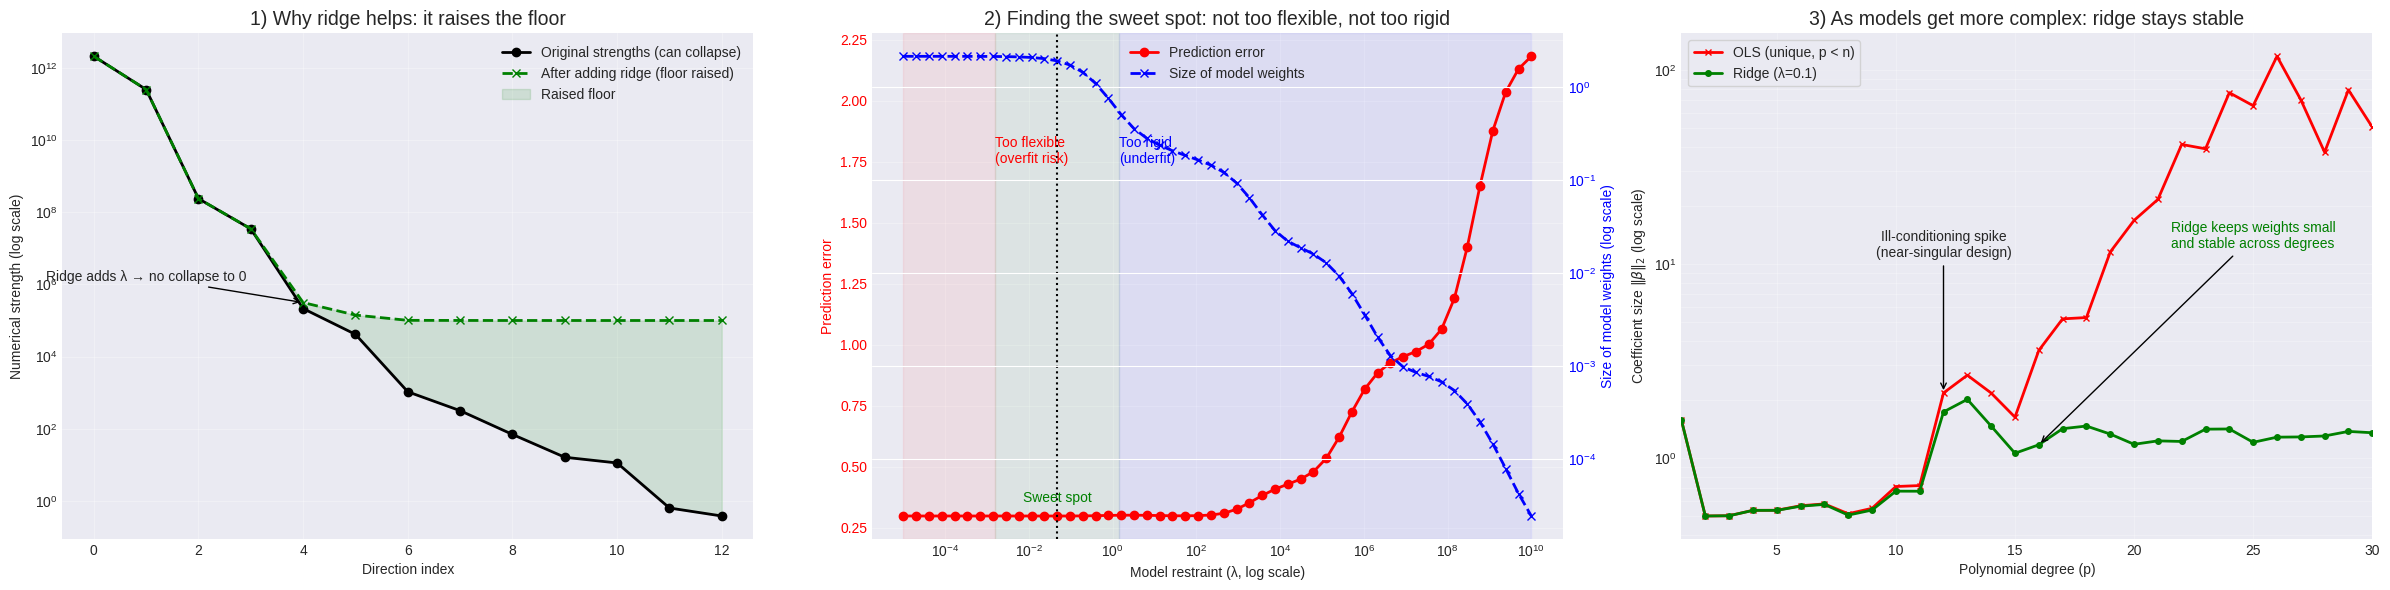

In [23]:
# BLOCK 5: Advanced Visualization (Plain-language + Stability in one figure)
import matplotlib.pyplot as plt
import numpy as np
import torch

y_target_safe = torch.as_tensor(y_train, dtype=torch.float64).view(-1, 1)
y_test_safe   = torch.as_tensor(y_test,  dtype=torch.float64).view(-1, 1)

DEGREE_ILL = 12
X_raw = construct_vandermonde_matrix(x_train, DEGREE_ILL).double()
eigs = torch.linalg.eigvalsh((X_raw.T @ X_raw)).flip(0).cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# -------- Plot 1 --------
ax = axes[0]
ax.plot(eigs, 'k-o', linewidth=2, label='Original strengths (can collapse)')
shifted = eigs + 1e5
ax.plot(shifted, 'g--x', linewidth=2, label='After adding ridge (floor raised)')
ax.fill_between(range(len(eigs)), eigs, shifted, color='green', alpha=0.12, label='Raised floor')
ax.set_yscale('log')
ax.set_title('1) Why ridge helps: it raises the floor', fontsize=14)
ax.set_xlabel('Direction index')
ax.set_ylabel('Numerical strength (log scale)')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right')
ax.annotate('Ridge adds λ → no collapse to 0', xy=(len(eigs)//3, shifted[len(eigs)//3]),
            xytext=(len(eigs)//7, shifted[len(eigs)//3]*4),
            arrowprops=dict(arrowstyle='->'), fontsize=10, ha='center')

# -------- Plot 2 --------
lambda_sweep = torch.logspace(-5, 10, 50, dtype=torch.float64)
lam_np = lambda_sweep.cpu().numpy()
beta_norms, test_mses = [], []
X_test_raw = construct_vandermonde_matrix(x_test, DEGREE_ILL).double()

for lam in lambda_sweep:
    beta = solve_ridge_analytical(X_raw, y_target_safe, float(lam))
    beta_norms.append(torch.linalg.norm(beta).item())
    y_pred = X_test_raw @ beta
    test_mses.append(compute_mse(y_test_safe, y_pred))

test_mses = np.asarray(test_mses)
beta_norms = np.asarray(beta_norms)
best_idx = int(np.argmin(test_mses))
best_lam = float(lam_np[best_idx])

ax1 = axes[1]
(line_err,) = ax1.semilogx(lam_np, test_mses, 'r-o', linewidth=2, label='Prediction error')
ax1.set_xlabel('Model restraint (λ, log scale)')
ax1.set_ylabel('Prediction error', color='r')
ax1.tick_params(axis='y', labelcolor='r')
ax1.grid(True, alpha=0.3)
ax1.axvline(best_lam, color='k', linestyle=':', linewidth=1.5)
ax1.set_title('2) Finding the sweet spot: not too flexible, not too rigid', fontsize=14)

ax2 = ax1.twinx()
(line_norm,) = ax2.semilogx(lam_np, beta_norms, 'b--x', linewidth=2, label='Size of model weights')
ax2.set_ylabel('Size of model weights (log scale)', color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_yscale('log')

left_hi  = max(lam_np.min(), best_lam/30)
right_lo = min(lam_np.max(), best_lam*30)
ax1.axvspan(lam_np.min(), left_hi, color='red', alpha=0.06)
ax1.axvspan(left_hi, right_lo, color='green', alpha=0.06)
ax1.axvspan(right_lo, lam_np.max(), color='blue', alpha=0.06)
ax1.text(left_hi, np.max(test_mses)*0.85, 'Too flexible\n(overfit risk)', fontsize=10, ha='left', va='top', color='red')
ax1.text(best_lam, np.min(test_mses)*1.15, 'Sweet spot', fontsize=10, ha='center', va='bottom', color='green')
ax1.text(right_lo, np.max(test_mses)*0.85, 'Too rigid\n(underfit)', fontsize=10, ha='left', va='top', color='blue')

lines = [line_err, line_norm]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper center')

# -------- Plot 3 (degree sweep limited to 30) --------
n_train = int(len(x_train))
MAX_DEG = 30
STEP = 1
degrees_ext = list(range(1, MAX_DEG + 1, STEP))
ols_deg, ols_norm, ridge_deg, ridge_norm = [], [], [], []
lambda_stable = 0.1

for d in degrees_ext:
    X_tr = construct_vandermonde_matrix(x_train, d).double()
    XtX = X_tr.T @ X_tr
    Xty = X_tr.T @ y_target_safe
    beta_ols = torch.linalg.solve(XtX, Xty)
    ols_deg.append(d)
    ols_norm.append(float(torch.linalg.norm(beta_ols).item()))
    beta_r = solve_ridge_analytical(X_tr, y_target_safe, lambda_stable)
    ridge_deg.append(d)
    ridge_norm.append(float(torch.linalg.norm(beta_r).item()))

ax3 = axes[2]
ax3.plot(ols_deg, ols_norm, 'r-', marker='x', ms=4, lw=2, label='OLS (unique, p < n)')
ax3.plot(ridge_deg, ridge_norm, 'g-o', ms=4, lw=2, label=f'Ridge (λ={lambda_stable})')
ax3.set_xlim(1, MAX_DEG)
ax3.set_yscale('log')
ax3.set_title('3) As models get more complex: ridge stays stable', fontsize=14)
ax3.set_xlabel('Polynomial degree (p)')
ax3.set_ylabel(r'Coefficient size $\|\beta\|_2$ (log scale)')
ax3.grid(True, which='both', alpha=0.25)
ax3.legend(loc='upper left', frameon=True)

if len(ols_deg) >= 2:
    j = int(np.argmax(np.diff(np.log10(np.maximum(1e-16, ols_norm)))))
    ax3.annotate('Ill-conditioning spike\n(near-singular design)',
                 xy=(ols_deg[j+1], ols_norm[j+1]),
                 xytext=(ols_deg[j+1], ols_norm[j+1]*5),
                 arrowprops=dict(arrowstyle='->'), fontsize=10, ha='center')
ax3.annotate('Ridge keeps weights small\nand stable across degrees',
             xy=(degrees_ext[len(degrees_ext)//2], ridge_norm[len(degrees_ext)//2]),
             xytext=(degrees_ext[len(degrees_ext)//-5], max(ridge_norm)*6),
             arrowprops=dict(arrowstyle='->'), fontsize=10, ha='center', color='green')

plt.tight_layout()
plt.show()


### Synthesis Points

1. **Regularization as Numerical Stabilization**: The $\lambda I$ term transforms an ill-conditioned problem (Part 2) into a well-conditioned, strictly convex optimization problem. The condition number reduction demonstrates how Ridge restores numerical stability that the Normal Equation $(X^T X)^{-1}$ lacked.

2. **Regularization as Complexity Control**: The penalty term constrains model complexity, preventing overfitting in the classical regime (p < n). The U-shaped test error curve shows the bias-variance tradeoff in action, with optimal $\lambda$ balancing fit and generalization.

3. **The Interpolation Threshold**: As p approaches n, unregularized OLS becomes unstable (as seen in the exploding test MSE), but Ridge remains stable. This transition point is where the classical bias-variance analysis begins to break down, foreshadowing the double descent phenomenon (Part 5).

4. **Connection to Part 2**: Regularization provides an analytical solution to the numerical instability that made the Normal Equation fail. The pseudoinverse (Part 2) was a workaround; Ridge is a principled solution that modifies the optimization problem itself.

5. **Foreshadowing Part 4**: Iterative optimizers (Part 4) will solve the same regularized problem using gradient descent, Newton's method, and L-BFGS. The implicit bias of these algorithms relates to regularization's explicit bias, providing complementary perspectives on complexity control.

6. **Foreshadowing Part 5**: The primary visualization (Test MSE vs Degree) shows the classical U-shape where regularization helps. Beyond the interpolation threshold (p > n), we will observe in Part 5 that test error can decrease again—the double descent phenomenon—challenging conventional wisdom about the bias-variance tradeoff.
